### The purpose of nba-api is to scrape basketball-reference.com and extract matchup information and team statistics
Jake Giguere giguere@bu.edu

disclaimer: This is software is soley for educational purposes. Please do not use this for gambling or sport-betting.

In [96]:
import os
import time
from io import StringIO

import pandas as pd
import requests
import tensorflow as tf
from bs4 import BeautifulSoup
import numpy as np
print("TensorFlow version:", tf.__version__)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

TensorFlow version: 2.16.2


In [98]:
# Dictionary mapping team names to their abbreviations
TEAM_MAP = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS"
}

# Reverse dictionary for abbreviation to full team name
ABBR_MAP = {abbr: team for team, abbr in TEAM_MAP.items()}

def get_team_name_or_abbr(input_str):
    """Convert a team name to its abbreviation or vice versa."""
    input_str = input_str.strip()
    
    # Check if the input is an abbreviation
    if input_str.upper() in ABBR_MAP:
        return ABBR_MAP[input_str.upper()]
    # Check if the input is a full team name
    elif input_str in TEAM_MAP:
        return TEAM_MAP[input_str]
    else:
        return "Team not found."

# Example Usage
print(get_team_name_or_abbr("Boston Celtics"))   # Output: "BOS"
print(get_team_name_or_abbr("LAL"))              # Output: "Los Angeles Lakers"
print(get_team_name_or_abbr("NYK"))              # Output: "New York Knicks"
print(get_team_name_or_abbr("Philadelphia 76ers"))  # Output: "PHI"
print(get_team_name_or_abbr("ATL"))              # Output: "Atlanta Hawks"


BOS
Los Angeles Lakers
New York Knicks
PHI
Atlanta Hawks


In [3]:
abv = list(TEAM_MAP.values())
abv

['ATL',
 'BOS',
 'BRK',
 'CHO',
 'CHI',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHO',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS']

### Retreive Data from 2022-2024

In [99]:
data = pd.read_excel('Data/offsets/offset.xlsx',sheet_name='Worksheet', header=0)

data = data.dropna(axis=0)

print(f'Data Shape:', data.shape)
print(f'First 5 rows: \n', data.head(5))
print(f'Column names:', data.columns)

Data Shape: (6516, 68)
First 5 rows: 
    Rk Team       Date   DRtg  AST  ORB  3PA  Opp           Result   MP  ...  \
0   1  DAL 2025-02-13  117.4   28   16   36  MIA       W, 118-113  240  ...   
1   2  GSW 2025-02-13   97.4   26   15   41  HOU        W, 105-98  240  ...   
2   3  HOU 2025-02-13  104.3   24    9   36  GSW        L, 98-105  240  ...   
3   4  LAC 2025-02-13  110.5   22    9   38  UTA  W, 120-116 (OT)  265  ...   
4   5  MIA 2025-02-13  122.6   23   11   36  DAL       L, 113-118  240  ...   

     TS%   eFG%  FT/FGA  ORtg.1  DRtg.1  FTr.1  3PAr.1  TS%.1  eFG%.1  \
0  0.608  0.583   0.144   117.4   122.6  0.286   0.396  0.552   0.527   
1  0.520  0.455   0.270    97.4   104.3  0.194   0.387  0.486   0.473   
2  0.486  0.473   0.108   104.3    97.4  0.303   0.461  0.520   0.455   
3  0.546  0.489   0.298   110.5   114.3  0.333   0.577  0.648   0.603   
4  0.552  0.527   0.187   122.6   117.4  0.178   0.400  0.608   0.583   

   FT/FGA.1  
0     0.187  
1     0.108  
2    

### Prepare the data for the Sequential Model

In [100]:



# Load the cleaned dataset

feature_columns = ['PTS.1', 
                'FG%', 'FG%.1',
                'FGA', 'FGA.1',
                '3P%', '3P%.1',
                '3PA', '3PA.1',
                'ORB', 'ORB.1',
                'TRB', 'TRB.1',
                'AST', 'AST.1',
                'TOV', 'TOV.1',
                'STL', 'STL.1',
                'PF', 'PF.1',
                'ORtg', 'ORtg.1',
                'DRtg', 'DRtg.1',
                'FT%', 'FT%.1',
                'FTA', 'FTA.1',        
                ]

# data.to_csv('Data/cleaned_offset', index=False)
features = data[feature_columns]
target = data['PTS']
print(features.isnull().sum())
print(features[features.isnull().any(axis=1)])

features = features.dropna(axis=0)  # Check for NaNs
# print(np.isinf(features).sum())  # Check for infinite values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1)

data[feature_columns] = data[feature_columns].apply(pd.to_numeric, errors='coerce')
data['PTS'] = data['PTS'].apply(pd.to_numeric, errors='coerce')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# scaler_y = MinMaxScaler()  # Alternatively, StandardScaler()
# y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
# 
print(X_train.shape)
# print(X_test[1:5])


PTS.1     0
FG%       0
FG%.1     0
FGA       0
FGA.1     0
3P%       0
3P%.1     0
3PA       0
3PA.1     0
ORB       0
ORB.1     0
TRB       0
TRB.1     0
AST       0
AST.1     0
TOV       0
TOV.1     0
STL       0
STL.1     0
PF        0
PF.1      0
ORtg      0
ORtg.1    0
DRtg      0
DRtg.1    0
FT%       0
FT%.1     0
FTA       0
FTA.1     0
dtype: int64
Empty DataFrame
Columns: [PTS.1, FG%, FG%.1, FGA, FGA.1, 3P%, 3P%.1, 3PA, 3PA.1, ORB, ORB.1, TRB, TRB.1, AST, AST.1, TOV, TOV.1, STL, STL.1, PF, PF.1, ORtg, ORtg.1, DRtg, DRtg.1, FT%, FT%.1, FTA, FTA.1]
Index: []

[0 rows x 29 columns]
(5864, 29)


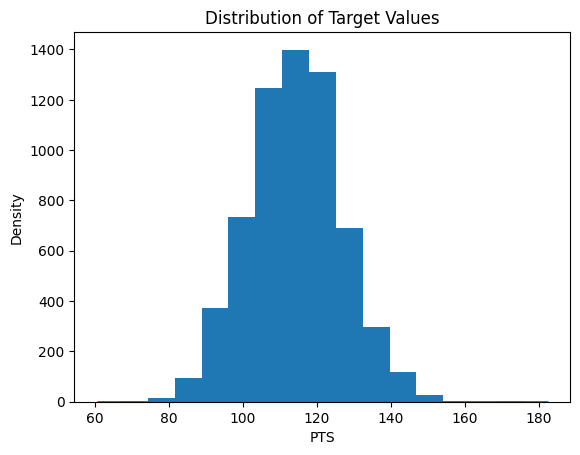

Target Value Stats:
count    6316.000000
mean      114.118113
std        12.434951
min        67.000000
25%       106.000000
50%       114.000000
75%       122.000000
max       176.000000
Name: PTS, dtype: float64


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(target, fill=True,)
plt.hist(target, bins=15)
plt.title("Distribution of Target Values")
plt.show()

print("Target Value Stats:")
print(target.describe())


### Check for NaNs or Infinite Values

In [41]:
import numpy as np

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import keras
from keras import layers, callbacks


In [42]:

model = keras.models.Sequential(
    [
    layers.Input(shape=(29,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    # layers.Dense(4, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(1)  # Output layer for regression
    ]
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=300, batch_size=8, validation_split=0.2, shuffle=True, callbacks=[lr_scheduler, early_stopping],)



Epoch 1/300
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7061.3574 - mae: 70.7043 - val_loss: 339.2696 - val_mae: 14.9694 - learning_rate: 0.0010
Epoch 2/300
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 262.5593 - mae: 13.1005 - val_loss: 153.0336 - val_mae: 9.8893 - learning_rate: 0.0010
Epoch 3/300
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 121.9186 - mae: 8.8219 - val_loss: 64.0317 - val_mae: 6.3853 - learning_rate: 0.0010
Epoch 4/300
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.1239 - mae: 5.6581 - val_loss: 32.1700 - val_mae: 4.6392 - learning_rate: 0.0010
Epoch 5/300
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.6131 - mae: 3.7558 - val_loss: 13.2583 - val_mae: 2.8880 - learning_rate: 0.0010
Epoch 6/300
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7377 - mae: 2.4514 - val_loss: 5.6964 - val_mae: 1.8195 - learning_rate: 0.0010
Epoch 7/300
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6634 - mae: 1.6646 - val_loss: 4.1945 - val_mae: 1.5270 - le

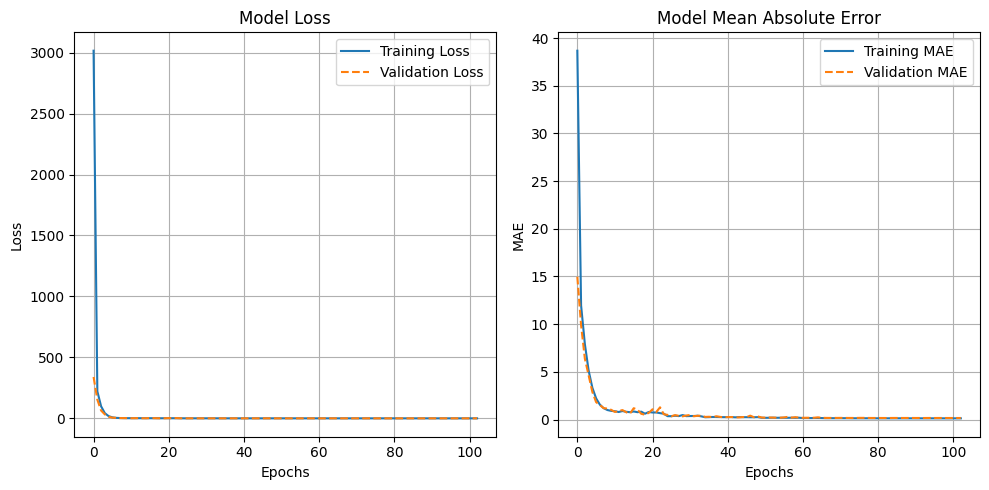

In [43]:
import matplotlib.pyplot as plt

# Assuming you have 'history.history' dictionary from model training
# Example: 'loss', 'val_loss', 'mae', and 'val_mae'

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [46]:
# Save the trained model right after training
model.save('adv_nba_model.keras')
print("Model saved as 'nba_model.h5'")

Model saved as 'nba_model.h5'


### Evaluate model

In [47]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Absolute Error: 0.16
Root Mean Squared Error: 0.21


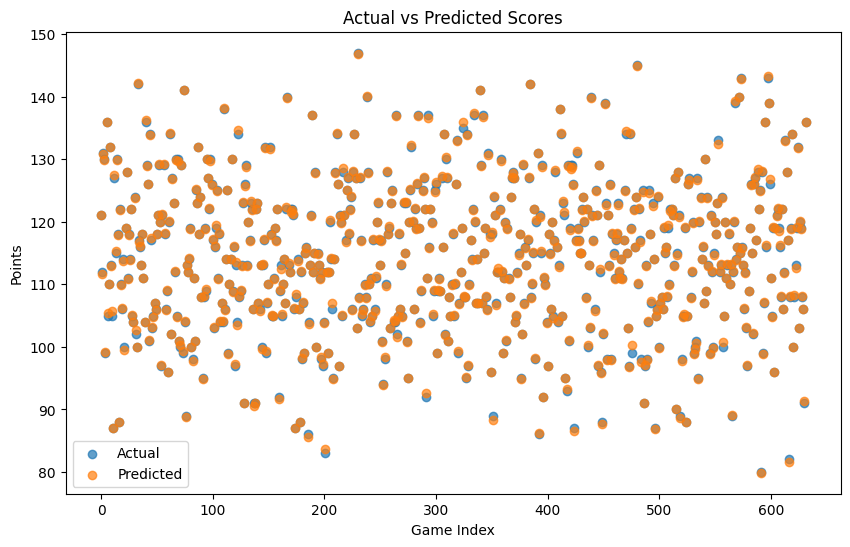

In [45]:
import matplotlib.pyplot as plt

# Assuming `y_test` is the actual values and `predictions` are your model's predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Game Index')
plt.ylabel('Points')
plt.title('Actual vs Predicted Scores')
plt.legend()
plt.show()

In [84]:
# Step 1: Scrape today's games
from datetime import datetime

def get_today_games():
    # Define the URL for the November 2024 NBA schedule
    url = "https://www.basketball-reference.com/leagues/NBA_2025_games-february.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the schedule table
    schedule_table = soup.find('table', {'id': 'schedule'})
    if not schedule_table:
        print("Schedule table not found.")
        return pd.DataFrame()
    
    # Extract rows from the table
    rows = schedule_table.find_all('tr')
    
    # Get today's date in the format used on the website
    today = datetime.now().strftime('%a, %b %-d, %Y')
    print(today)
    tmrw = "Wed, Feb 12, 2025"
    print(today)
    # Initialize a list to hold today's games
    games_today = []
    
    for row in rows:
        # Extract the date cell
        date_cell = row.find('th', {'data-stat': 'date_game'})
        if date_cell and date_cell.text.strip() == today:
            # Extract team names
            away_team = row.find('td', {'data-stat': 'visitor_team_name'}).text.strip()
            home_team = row.find('td', {'data-stat': 'home_team_name'}).text.strip()
            games_today.append({'home_team': home_team, 'away_team': away_team})
        if date_cell and date_cell.text.strip() == tmrw:
            # Extract team names
            away_team = row.find('td', {'data-stat': 'visitor_team_name'}).text.strip()
            home_team = row.find('td', {'data-stat': 'home_team_name'}).text.strip()
            games_today.append({'home_team': home_team, 'away_team': away_team})
            

    
    # Convert the list to a DataFrame
    return pd.DataFrame(games_today)

# Fetch today's games
today_games = get_today_games()
print("Today's Matchups:")


print(today_games)


Thu, Feb 13, 2025
Thu, Feb 13, 2025
Today's Matchups:
                 home_team               away_team
0           Boston Celtics       San Antonio Spurs
1            Orlando Magic       Charlotte Hornets
2       Washington Wizards          Indiana Pacers
3            Brooklyn Nets      Philadelphia 76ers
4          New York Knicks           Atlanta Hawks
5          Toronto Raptors     Cleveland Cavaliers
6            Chicago Bulls         Detroit Pistons
7   Minnesota Timberwolves         Milwaukee Bucks
8     New Orleans Pelicans        Sacramento Kings
9    Oklahoma City Thunder              Miami Heat
10         Houston Rockets            Phoenix Suns
11          Denver Nuggets  Portland Trail Blazers
12               Utah Jazz      Los Angeles Lakers
13        Dallas Mavericks   Golden State Warriors
14    Los Angeles Clippers       Memphis Grizzlies
15         Houston Rockets   Golden State Warriors
16    New Orleans Pelicans        Sacramento Kings
17        Dallas Mavericks  

Get team current team per game data

In [91]:
def get_team_per_game_stats(team_abbr):
    data = pd.read_excel('Data/tpg.xlsx', sheet_name='Worksheet', header=0)
    # data = pd.read_csv('Data/window/nbaAvgWindow.csv', header=0)
    data = data[data['Team'] == team_abbr]
    # data = data[data['Team_Name'] == team_abbr]

    # Extract only the required columns
    feature_columns = ['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 
                       'AST', 'TOV', 'STL', 'PF', 'ORtg', 'DRtg', 'FTA', 'FT%']
    
    # If there is no matching data, return zeros
    if data.empty:
        return {col: 0 for col in feature_columns}
    
    # Extract scalar values
    team_stats = data.iloc[0]  # Assume the first matching row is correct
    return {col: team_stats.get(col, 0) for col in feature_columns}
 
        
    
home = get_team_name_or_abbr(today_games.iloc[0][0])
away = get_team_name_or_abbr(today_games.iloc[0][1])

home_teams = today_games['home_team']
away_teams = today_games['away_team']

home = get_team_per_game_stats(home)
away = get_team_per_game_stats(away)

print(home)



{'PTS': 117.3, 'FG%': 0.458, 'FGA': 90.7, '3P%': 0.365, '3PA': 48.5, 'ORB': 10.9, 'TRB': 44.8, 'AST': 25.7, 'TOV': 11.8, 'STL': 7.6, 'PF': 16.3, 'ORtg': 119.4, 'DRtg': 110.4, 'FTA': 20.9, 'FT%': 0.792}


/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_24886/290998982.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  home = get_team_name_or_abbr(today_games.iloc[0][0])
/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_24886/290998982.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  away = get_team_name_or_abbr(today_games.iloc[0][1])


### Create a match up vector for both teams to follow the model features

In [92]:
def create_matchup_feature_vector(home_team, away_team, team_abbreviation_func):
    """
    For a given matchup, fetch stats for the home and away teams,
    and create a combined feature vector.
    """
    home_abbr = team_abbreviation_func(home_team)
    away_abbr = team_abbreviation_func(away_team)
    
    # Get stats for both teams
    home_stats = get_team_per_game_stats(home_abbr)
    away_stats = get_team_per_game_stats(away_abbr)
    
    
    # Rename away team columns with '.1' suffix
    away_stats = {f"{key}.1": value for key, value in away_stats.items()}
    
    # home_stats['Home/Away'] = 0
    # away_stats['Home/Away.1'] = 1
    
    # Combine home and away team stats
    combined_stats = {**home_stats, **away_stats}
    
    return combined_stats

### Get Data for todays games home teams

In [93]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_matchup_feature_vector(
        game['home_team'],game['away_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
home_feature_df = pd.DataFrame(feature_vectors)



print("Feature Vectors for Today's Matchups:")
print(home_feature_df.columns)


# Filter the DataFrame to include only the columns your model expects
home_feature_df = home_feature_df[feature_columns]

# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(home_feature_df)
print("Shape of feature_df:", home_feature_df.shape)

Feature Vectors for Today's Matchups:
Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'ORtg', 'DRtg', 'FTA', 'FT%', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1',
       '3PA.1', 'ORB.1', 'TRB.1', 'AST.1', 'TOV.1', 'STL.1', 'PF.1', 'ORtg.1',
       'DRtg.1', 'FTA.1', 'FT%.1'],
      dtype='object')
Adjusted Feature Vectors:
    PTS.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0   112.8  0.458  0.459  90.7   89.1  0.365  0.351  48.5   40.0  10.9  ...   
1   106.9  0.439  0.429  85.5   89.8  0.305  0.343  36.5   40.7  11.2  ...   
2   115.9  0.434  0.491  90.5   88.3  0.327  0.376  38.2   34.2  10.8  ...   
3   109.0  0.440  0.455  85.0   85.9  0.353  0.351  38.9   36.4  10.1  ...   
4   115.3  0.495  0.458  88.6   91.9  0.379  0.343  35.0   37.3  10.8  ...   
5   122.2  0.469  0.498  89.6   90.1  0.348  0.392  32.5   41.1  11.8  ...   
6   112.0  0.466  0.466  92.0   89.4  0.372  0.360  43.0   36.3   9.8  ...   
7   114.6  0.465  0

In [94]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_matchup_feature_vector(
        game['away_team'],game['home_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
away_feature_df = pd.DataFrame(feature_vectors)



# print("Feature Vectors for Today's Matchups:")
# print(away_feature_df.columns)


# Filter the DataFrame to include only the columns your model expects
away_feature_df = away_feature_df[feature_columns]

# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(away_feature_df)
print("Shape of feature_df:", away_feature_df.shape)

Adjusted Feature Vectors:
    PTS.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0   117.3  0.459  0.458  89.1   90.7  0.351  0.365  40.0   48.5  11.2  ...   
1   103.8  0.429  0.439  89.8   85.5  0.343  0.305  40.7   36.5  13.0  ...   
2   107.0  0.491  0.434  88.3   90.5  0.376  0.327  34.2   38.2   9.0  ...   
3   105.4  0.455  0.440  85.9   85.0  0.351  0.353  36.4   38.9   9.9  ...   
4   117.9  0.458  0.495  91.9   88.6  0.343  0.379  37.3   35.0  12.2  ...   
5   111.1  0.498  0.469  90.1   89.6  0.392  0.348  41.1   32.5  10.4  ...   
6   116.5  0.466  0.466  89.4   92.0  0.360  0.372  36.3   43.0  11.3  ...   
7   111.2  0.484  0.465  86.8   85.5  0.385  0.387  36.6   39.2   8.5  ...   
8   109.8  0.475  0.446  91.1   90.3  0.347  0.346  36.0   35.3  10.9  ...   
9   116.4  0.457  0.472  87.0   91.9  0.367  0.355  38.8   38.4   9.4  ...   
10  114.0  0.477  0.449  85.4   93.3  0.379  0.344  37.1   35.7   9.2  ...   
11  120.8  0.450  0.506  88.5   89.7  

### Load out model 'nba_model.keras' and predict Home team scores

In [95]:
loaded_model = tf.keras.models.load_model('adv_nba_model.keras')
# loaded_model = model
# Example: Make predictions using the loaded model

scaler = StandardScaler()
home_scaled_features = scaler.fit_transform(home_feature_df)
away_scaled_features = scaler.fit_transform(away_feature_df)

# Make predictions using the loaded model
home_predicted_scores = loaded_model.predict(home_scaled_features)
away_predicted_scores = loaded_model.predict(away_scaled_features)

# Add the predicted scores to the original DataFrame
today_games['home_predicted_scores'] = home_predicted_scores.flatten()
today_games['away_predicted_scores'] = away_predicted_scores.flatten()

# Display the results
print("\nPredicted Scores for Today's Matchups:")
print(today_games)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted Scores for Today's Matchups:
                 home_team               away_team  home_predicted_scores  \
0           Boston Celtics       San Antonio Spurs             131.825638   
1            Orlando Magic       Charlotte Hornets             101.364426   
2       Washington Wizards          Indiana Pacers              94.246544   
3            Brooklyn Nets      Philadelphia 76ers              99.708595   
4          New York Knicks           Atlanta Hawks             145.281235   
5          Toronto Raptors     Cleveland Cavaliers             115.343819   
6            Chicago Bulls         Detroit Pistons             115.655952   
7   Minnesota Timberwolves         Milwaukee Bucks             116.452522   
8     New Orleans Pelicans        Sacramento Kings             106.737823   
9    Oklahoma City Thunder              Miami Heat             126.916069   
10         Houston Rockets          

-22.85204426666664


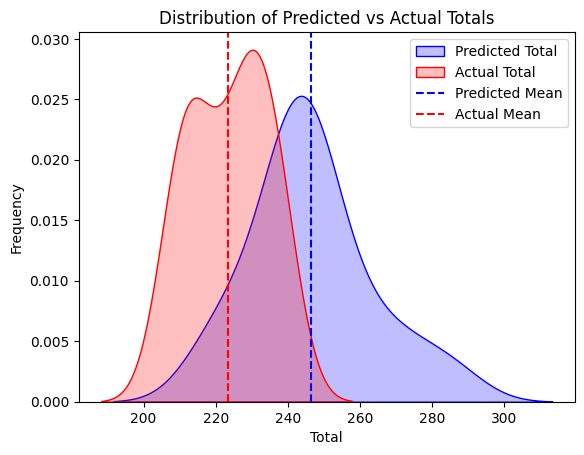

In [101]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
xlsx = pd.read_excel('data/nba.xlsx', sheet_name='Adv')
# print(xlsx.head())
xlsx.columns = xlsx.columns.str.strip()
team_name = 'BOS'
cle = xlsx[(xlsx['home'] == team_name) | (xlsx["away"] == team_name)]
# print(cle)
sns.kdeplot(cle['pred total'], color='blue', label='Predicted Total', fill=True)
sns.kdeplot(cle['Total Actual'], color='red', label='Actual Total', fill=True)

plt.axvline(cle['pred total'].mean(), color='blue', linestyle='--', label='Predicted Mean')
plt.axvline(cle['Total Actual'].mean(), color='red', linestyle='--', label='Actual Mean')
print(cle['Total Actual'].mean() - cle['pred total'].mean())
plt.title('Distribution of Predicted vs Actual Totals')
plt.xlabel('Total')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
cle['error'] = cle['pred total'] - cle['Actual']
sns.kdeplot(cle['error'], shade=True, color='purple')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.show()


### H2H Data


In [289]:
def get_h2h_stats(teamA, teamB):
    """
    Scrapes the 'per_game' table for a given team using its abbreviation.
    """
    url = f"https://stathead.com/basketball/versus-finder.cgi?request=1&match=versus_teamvteam&seasons_type=forall&year_min=2024&year_max=2025&team_id1={teamA}&team_id2={teamB}"
    
            
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the per-game table
    h2h_table = soup.find('table', {'id': 'stats_h2h_per_game_rs'})
    if not h2h_table:
        #TODO get overall per game table
        print(f"Per-game table not found for {teamA} vs. {teamB}.")
        return {}
    if h2h_table:
        table = StringIO(str(h2h_table))
        df = pd.read_html(table)[0]
        

        feature_columns = ['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL', 'PF']
        relevant_stats = {col: df.get(col, 0) for col in feature_columns}
        
        return relevant_stats


In [290]:
def create_h2h_feature_vector(home_team, away_team, team_abbreviation_func):
    """
    For a given matchup, fetch stats for the home and away teams,
    and create a combined feature vector.
    """
    home_abbr = team_abbreviation_func(home_team)
    away_abbr = team_abbreviation_func(away_team)
    
    # Get stats for both teams
    h2h_stats = pd.DataFrame(get_h2h_stats(home_abbr, away_abbr))
    home_stats = h2h_stats.iloc[0]
    away_stats = h2h_stats.iloc[1]                
    
    # Rename away team columns with '.1' suffix
    away_stats = {f"{key}.1": value for key, value in away_stats.items()}
    
    # home_stats['Home/Away'] = 0
    # away_stats['Home/Away.1'] = 1
    
    # Combine home and away team stats
    combined_stats = {**home_stats, **away_stats}
    
    return combined_stats

In [291]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_h2h_feature_vector(
        game['home_team'],game['away_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
feature_df = pd.DataFrame(feature_vectors)



print("Feature Vectors for Today's Matchups:")
print(feature_df.columns)


# Filter the DataFrame to include only the columns your model expects


# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(home_feature_df)
print("Shape of feature_df:", home_feature_df.shape)

Feature Vectors for Today's Matchups:
Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
Adjusted Feature Vectors:
   PTS.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0  107.1  0.455  0.473  83.6   80.5  0.331  0.364  33.2   31.6   9.8  ...   
1  117.4  0.488  0.467  95.3   95.7  0.409  0.342  42.3   38.9  14.7  ...   
2  121.6  0.480  0.484  94.6   91.7  0.354  0.370  32.7   33.6  13.1  ...   
3  111.8  0.421  0.464  89.0   84.0  0.297  0.357  37.0   39.3  13.0  ...   
4  114.3  0.424  0.464  87.6   91.7  0.328  0.369  41.4   38.7  10.0  ...   
5  110.2  0.483  0.463  89.4   91.4  0.384  0.351  33.3   37.0   9.9  ...   

    TRB  TRB.1   AST  AST.1   TOV  TOV.1  STL  STL.1    PF  PF.1  
0  40.4   41.6  21.9   24.1  16.1   16.1  8.4    8.7  22.0  21.2  
1  51.6   42.3  27.0   28.3  14.7   12.2  7.

In [292]:
loaded_model = tf.keras.models.load_model('nba_model.keras')

# loaded_model = model
# Example: Make predictions using the loaded model
print(feature_df.columns)

home_vect_df = feature_df.drop(['PTS'], axis=1)
away_vect_df = feature_df.drop(['PTS.1'], axis=1)

# home_vect = vect_df.drop(['PTS'], axis=1)
# away_vect = vect_df.drop(['PTS.1'], axis=1)

scaler = StandardScaler()
home_scaled_features = scaler.fit_transform(home_vect_df)
away_scaled_features = scaler.fit_transform(away_vect_df)

# Make predictions using the loaded model
home_predicted_scores = loaded_model.predict(home_scaled_features)
away_predicted_scores = loaded_model.predict(away_scaled_features)

# Add the predicted scores to the original DataFrame


today_games['home_predicted_scores'] = home_predicted_scores.flatten()
today_games['away_predicted_scores'] = away_predicted_scores.flatten()

# Display the results
print("\nPredicted Scores for Today's Matchups:")
print(today_games)

Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Predicted Scores for Today's Matchups:
                home_team          away_team  home_predicted_scores  \
0           Orlando Magic      Brooklyn Nets             114.819077   
1          Boston Celtics     Indiana Pacers             119.169876   
2         Toronto Raptors      Atlanta Hawks             142.273758   
3         Houston Rockets         Miami Heat             116.004677   
4   Oklahoma City Thunder  Memphis Grizzlies             105.903557   
5  Minnesota Timberwolves  San Antonio Spurs              98.664680   

   away_predicted_scores  teamA_predicted_scores  teamB_predicted_scores  
0             120.055534              112.055656              115.632149  
1             127.

-14.681865111111136


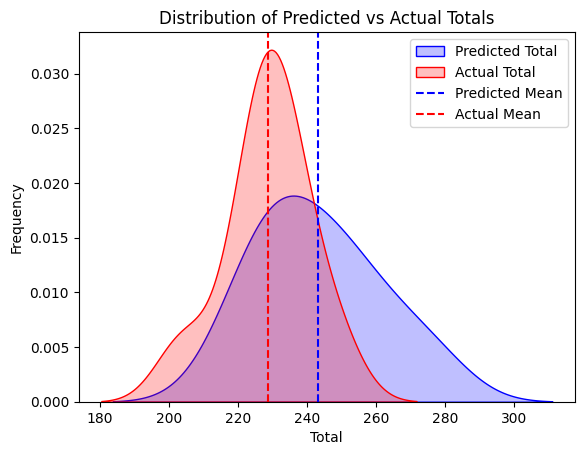

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
xlsx = pd.read_excel('data/nba.xlsx', sheet_name='Adv')
# print(xlsx.head())
xlsx.columns = xlsx.columns.str.strip()
team_name = 'OKC'
cle = xlsx[(xlsx['home'] == team_name) | (xlsx["away"] == team_name)]
# print(cle)
sns.kdeplot(cle['pred total'], color='blue', label='Predicted Total', fill=True)
sns.kdeplot(cle['Total Actual'], color='red', label='Actual Total', fill=True)

plt.axvline(cle['pred total'].mean(), color='blue', linestyle='--', label='Predicted Mean')
plt.axvline(cle['Total Actual'].mean(), color='red', linestyle='--', label='Actual Mean')
print(cle['Total Actual'].mean() - cle['pred total'].mean())
plt.title('Distribution of Predicted vs Actual Totals')
plt.xlabel('Total')
plt.ylabel('Frequency')
plt.legend()
plt.show()
